In [397]:
import pandas as pd
import numpy as np
from database import engine
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from ingredient_map import create_ingredient_map
from quant_preprocess import query_data
from quant_preprocess import cols_to_lower
from quant_preprocess import get_cols_list
from quant_preprocess import query_and_preprocess_data
from quant_preprocess import shape_data_long
from quant_preprocess import merge_long
from quant_preprocess import pivot_wide
from quant_preprocess import recode_ingredients
import os


INPUT_PATH = os.path.join("..//data", "ingredient_prices_clean.csv")
OUTPUT_DIR = "data"
df_drinks = query_and_preprocess_data()
liquors = ["strdrink","brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","brandy","scotch","grain alcohol"]

In [398]:
def create_dummies(df):
    
    headers = df.columns[1:]
    d = {'strdrink': df['strdrink'].values.tolist()}
    for e in range(0, len(headers)):
        d[headers[e]] = (df[str(headers[e])] > 0).astype(int).values.tolist()
    return pd.DataFrame.from_dict(d)

In [399]:
def summmary_of_oz(df):
   
    return df.describe().transpose().sort_values('mean',
                                ascending = False).head(10)

In [400]:
def summary_of_usage():
    
    df = query_and_preprocess_data()
    df = create_dummies(df)
    dum_df = create_dummies(df)
    headers = dum_df.columns[1:].values.tolist()
    data = dum_df.describe().transpose().sort_values('mean', 
                                    ascending=False).head(10)
        
    return data
    

In [401]:
def get_amount_table():
    df = query_data()
    ingred_cols = get_cols_list(df, "stringredient")
    measure_cols = get_cols_list(df, "strmeasure")
    df[ingred_cols] = cols_to_lower(df, ingred_cols)
    ingredient_long = shape_data_long(
            df, ingred_cols, "stringredient", "", "ingredient"
        )
    measure_long = shape_data_long(df, measure_cols, "strmeasure", "_clean", "amount")
    combined_long = merge_long(ingredient_long, measure_long)
    ingredient_dict = create_ingredient_map()
    recoded_long = recode_ingredients(combined_long, ingredient_dict)
    combined_wide = pivot_wide(recoded_long)
    return combined_wide


In [402]:
get_amount_table()

ingredient,strdrink,absinthe,advocaat,aperitif,aquavit,baileys,beer,bitters,bourbon,brandy,butter,cachaca,carbonated water,champagne,cherry heering,club soda,coffee,cognac,cornstarch,drambuie,dry vermouth,dubonnet rouge,egg,erin cream,everclear,flavored rum,flavored vodka,food coloring,frangelico,fruit,fruit juice,galliano,gin,glycerine,grain alcohol,herb,hot sauce,ice,ice cream,jagermeister,liqueur,milk,mix,nut,olive brine,pernod,pisang ambon,pisco,port,prosecco,red wine,ricard,rum,sambuca,sarsaparilla,schnapps,scotch,sherry,soda,soy sauce,spice,sugar,sugard,sweet and sour,tequila,tonic water,vermouth,vodka,water,whiskey,wine,zima
0,1-900-FUK-MEUP,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,110 in the shade,0.0,0.0,0.00,0.0,0.00,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.5,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,151 Florida Bushwacker,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,11.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.50,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,155 Belmont,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,4.50,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.50,0.0,0.0,0.0,0.0
4,24k nightmare,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,Zizi Coin-coin,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.68,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.69,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
624,Zoksel,0.0,0.0,0.00,0.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
625,Zombie,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
626,Zorbatini,0.0,0.0,0.25,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.25,0.0,0.0,0.0,0.0


In [403]:
def drop_big_drinks():
    # we drop the ones that have more than 6 ounces bc this heavily
    # affects price and messes up any relationship between liquor and cost
    df = get_amount_table()
    df = df.set_index("strdrink")
    df = df.transpose()
    for d in df:
        if (df.sum(axis=0)[d] > 6):
            df = df.drop(d,axis=1)
    return df.columns.values.tolist()
    


In [404]:
def prices_list():
    
    df_prices = pd.read_csv(INPUT_PATH, header=None)
    df_prices = df_prices.sort_values(0, ascending=True)
    df_prices = df_prices.transpose()
    prices = df_prices.loc[1].values.tolist()
    return prices

In [405]:
def combine_prices_ingredients():
    
    ingredients = get_amount_table()
    ingredients = ingredients.transpose()
    ingredients =  ingredients.drop(labels="strdrink",axis=0)
    prices = prices_list()
    ingredients["prices"] = prices
    return ingredients

In [406]:
def get_ingredient_cost():
    df = get_amount_table()
    drinks = df["strdrink"].values.tolist()
    df = combine_prices_ingredients()
    for i in range(0,627):
        df[i] = df[i]*df["prices"]
    df= df.transpose()
    df = df.drop(labels = "prices", axis = 0)
    df["strdrink"] = drinks
    df = df.transpose()
    
    return df

In [407]:
def drop_all_zero_dummies():
    
    # we drop the columns that do not have any liquor in them
    # we may add beer or wine in there, but I wanted to
    # focus on liquor
    liquors = ["strdrink","brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","brandy","scotch","grain alcohol"]
    dummies = create_dummies(df_drinks)
    dummies = dummies[liquors].replace(0, np.nan)
    dummies = dummies.dropna(how='all', axis=0)
    dummies = dummies.replace(np.nan, 0)
    
    return dummies

In [408]:
def model_data():
    
    # we inner join the columns with at least one liquor
    # and a drink that is less than 6 ounces
    liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","scotch","grain alcohol"]
    data = get_ingredient_cost()
    amounts = get_amount_table()
    data.columns = data.loc['strdrink']
    drinks = data.columns.values.tolist()
    data = data.drop("strdrink", axis=0)
    df_cost = data.transpose()
    cost = df_cost.sum(axis=1).values.tolist()
    amounts = amounts.sum(axis=1).values.tolist()
    d = {
        "strdrink": drinks,
        "cost": cost,
        "total oz": amounts
    }
    drinks = drop_big_drinks()
    df = pd.DataFrame(d).set_index("strdrink").transpose()
    df = df[drinks].transpose()
    dummies = create_dummies(df_drinks).set_index("strdrink")
    dummies = dummies[liquors]
    dummies = dummies.replace(0, np.nan)
    dummies = dummies.dropna(how='all', axis=0)
    dummies = dummies.replace(np.nan, 0)
    model = dummies.merge(df, how="inner",on="strdrink")
    

    
    
    return model

In [409]:
model = model_data()
model

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]


,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,scotch,grain alcohol,cost,total oz
strdrink,,,,,,,,,,,,,
1-900-FUK-MEUP,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.400374,2.50
252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.200000,1.50
3 Wise Men,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.310100,0.99
3-Mile Long Island Iced Tea,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.454560,4.08
410 Gone,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.026387,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
White Russian,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.845447,4.00
Winter Paloma,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.292160,5.19
Winter Rita,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.758892,3.69


In [410]:
corr = model.corr()
corr

,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,scotch,grain alcohol,cost,total oz
brandy,1.000000,-0.120575,-0.123413,-0.226889,-0.082931,-0.037618,-0.064554,-0.076142,-0.019647,-0.059481,-0.026548,-0.160199,-0.082307
gin,-0.120575,1.000000,-0.116679,-0.265057,-0.230429,-0.063667,-0.185255,-0.034068,-0.185255,-0.179000,-0.044931,0.182276,0.096439
tequila,-0.123413,-0.116679,1.000000,-0.015853,-0.104051,-0.025832,-0.075165,-0.052285,-0.075165,-0.072627,-0.018230,-0.067754,0.044808
vodka,-0.226889,-0.265057,-0.015853,1.000000,-0.132041,-0.047491,-0.138186,-0.096124,-0.099397,-0.133521,-0.033515,-0.293926,-0.008033
whiskey,-0.082931,-0.230429,-0.104051,-0.132041,1.000000,-0.031716,-0.041370,-0.064196,0.009547,-0.036693,-0.022383,-0.013057,0.065580
flavored rum,-0.037618,-0.063667,-0.025832,-0.047491,-0.031716,1.000000,-0.022911,-0.015937,-0.022911,-0.022138,-0.005557,-0.111726,-0.047459
flavored vodka,-0.064554,-0.185255,-0.075165,-0.138186,-0.041370,-0.022911,1.000000,-0.046374,-0.066667,-0.064416,-0.016169,-0.195627,0.044118
cognac,-0.076142,-0.034068,-0.052285,-0.096124,-0.064196,-0.015937,-0.046374,1.000000,-0.046374,-0.044808,-0.011247,0.265024,0.019819
bourbon,-0.019647,-0.185255,-0.075165,-0.099397,0.009547,-0.022911,-0.066667,-0.046374,1.000000,0.004294,-0.016169,0.051841,-0.097739
scotch,-0.059481,-0.179000,-0.072627,-0.133521,-0.036693,-0.022138,-0.064416,-0.044808,0.004294,1.000000,-0.015623,0.548717,-0.115086


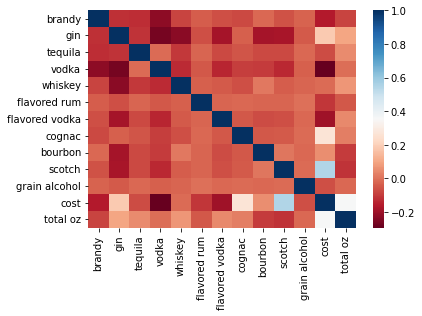

In [411]:
corr_heat = sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,cmap="RdBu")


In [412]:
df["cost"].corr(df["total oz"])
#justification for including total oz in regression

0.3533227866628533

In [413]:
def check_covar_costs():
    df_prices = pd.read_csv(INPUT_PATH, header=None)
    df_prices = df_prices.transpose()
    df_prices.columns = df_prices.loc[0]
    df_prices = df_prices.drop(0)
    df_prices = df_prices[["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","brandy","scotch","grain alcohol"]]
    return df_prices

In [414]:
check_covar_costs()

,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,brandy,scotch,grain alcohol
1,0.394,0.788,0.659687,0.391845,0.57,0.5,0.39668,2.263396,1.1,0.394,2.3,0.246667


In [415]:
def ols_regression():
    """Perform OLS regression of cost on types of alcohol"""

    df = model_data()
    x_cols = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","brandy","scotch","grain alcohol", "total oz"]
 
    x = df[x_cols]
    y = df["cost"]
    display(df[x_cols])


    model = sm.OLS(y, sm.add_constant(x)).fit()
    model_summary = model.summary()

    fig, ax = plt.subplots(figsize=(12, 7))

    ax.text(
        0.01, 0.05, str(model_summary), {"fontsize": 10}, fontproperties="monospace"
    )
    ax.axis("off")
    plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]


,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,brandy,scotch,grain alcohol,total oz
strdrink,,,,,,,,,,,,,
1-900-FUK-MEUP,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.50
252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.50
3 Wise Men,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.99
3-Mile Long Island Iced Tea,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.08
410 Gone,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
White Russian,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00
Winter Paloma,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.19
Winter Rita,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.69


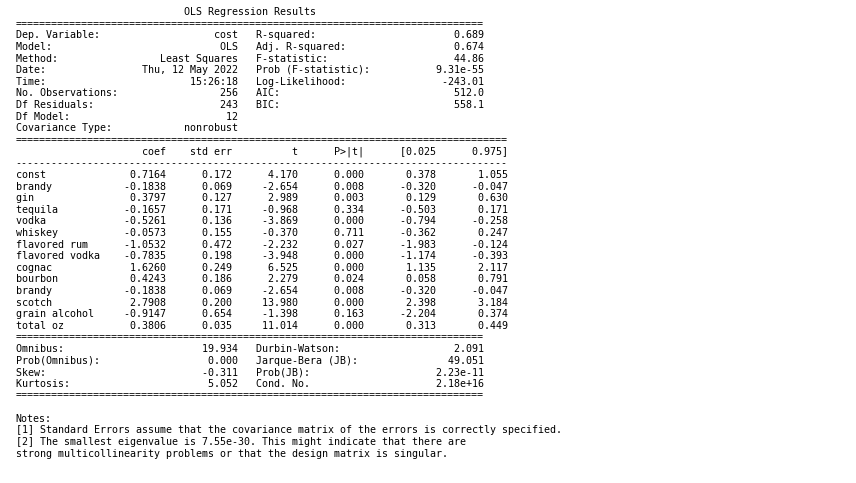

In [416]:
ols_regression()

In [418]:
INPUT_PATH = os.path.join("..//data", "ABV_list.csv")
OUTPUT_DIR = "ABV_data"
df_drinks = get_amount_table()
from prices_cleaning import load_ingredients
liquors = ["absinthe","advocaat","aperitif","aquavit","baileys","beer","bitters","bourbon","brandy", "cachaca","champagne", "cherry heering", "cognac", "drambuie","dry vermouth","dubonnet rouge", "erin cream", "everclear", "flavored rum","flavored vodka","frangelico","galliano", "gin", "grain alcohol","jagermeister", "liqueur", "pernod", "pisang ambon", "pisco","port","prosecco","red wine", "ricard","rum","sambuca","sarsaparilla","scotch","sherry","tequila", "vermouth","vodka", "whiskey","wine", "zima"]

In [419]:
get_amount_table()

ingredient,strdrink,absinthe,advocaat,aperitif,aquavit,baileys,beer,bitters,bourbon,brandy,butter,cachaca,carbonated water,champagne,cherry heering,club soda,coffee,cognac,cornstarch,drambuie,dry vermouth,dubonnet rouge,egg,erin cream,everclear,flavored rum,flavored vodka,food coloring,frangelico,fruit,fruit juice,galliano,gin,glycerine,grain alcohol,herb,hot sauce,ice,ice cream,jagermeister,liqueur,milk,mix,nut,olive brine,pernod,pisang ambon,pisco,port,prosecco,red wine,ricard,rum,sambuca,sarsaparilla,schnapps,scotch,sherry,soda,soy sauce,spice,sugar,sugard,sweet and sour,tequila,tonic water,vermouth,vodka,water,whiskey,wine,zima
0,1-900-FUK-MEUP,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,110 in the shade,0.0,0.0,0.00,0.0,0.00,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.5,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,151 Florida Bushwacker,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,11.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.50,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,155 Belmont,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,4.50,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.50,0.0,0.0,0.0,0.0
4,24k nightmare,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,Zizi Coin-coin,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.68,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.69,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
624,Zoksel,0.0,0.0,0.00,0.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
625,Zombie,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
626,Zorbatini,0.0,0.0,0.25,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.25,0.0,0.0,0.0,0.0


In [420]:
def load_ingredients():

    df = query_and_reshape_long()
    recoded = recode_long_data(df)
    summary = recoded[["ingredient", "amount"]].groupby("ingredient").agg(["mean", "sum"])
    return summary.index.values.tolist()



In [421]:
load_ingredients()

['absinthe',
 'advocaat',
 'aperitif',
 'aquavit',
 'baileys',
 'beer',
 'bitters',
 'bourbon',
 'brandy',
 'butter',
 'cachaca',
 'carbonated water',
 'champagne',
 'cherry heering',
 'club soda',
 'coffee',
 'cognac',
 'cornstarch',
 'drambuie',
 'dry vermouth',
 'dubonnet rouge',
 'egg',
 'erin cream',
 'everclear',
 'flavored rum',
 'flavored vodka',
 'food coloring',
 'frangelico',
 'fruit',
 'fruit juice',
 'galliano',
 'gin',
 'glycerine',
 'grain alcohol',
 'herb',
 'hot sauce',
 'ice',
 'ice cream',
 'jagermeister',
 'liqueur',
 'milk',
 'mix',
 'nut',
 'olive brine',
 'pernod',
 'pisang ambon',
 'pisco',
 'port',
 'prosecco',
 'red wine',
 'ricard',
 'rum',
 'sambuca',
 'sarsaparilla',
 'schnapps',
 'scotch',
 'sherry',
 'soda',
 'soy sauce',
 'spice',
 'sugar',
 'sugard',
 'sweet and sour',
 'tequila',
 'tonic water',
 'vermouth',
 'vodka',
 'water',
 'whiskey',
 'wine',
 'zima']

In [424]:
def model_1():
    
    liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]
    number = number_of_ingredients()
    data = get_ingredient_cost()
    amounts = get_amount_table()
    data.columns = data.loc['strdrink']
    drinks = data.columns.values.tolist()
    data = data.drop("strdrink", axis=0)
    df_cost = data.transpose()
    cost = df_cost.sum(axis=1).values.tolist()
    amounts = amounts.sum(axis=1).values.tolist()
    d = {
        "strdrink": drinks,
        "cost": cost,
        "total oz": amounts
    }
    drinks = drop_big_drinks()
    df = pd.DataFrame(d).set_index("strdrink").transpose()
    df = df[drinks].transpose()
    df["number of ingredients"] = number
    dummies = create_dummies().set_index("strdrink")
    dummies = dummies[liquors]
    dummies = dummies.replace(0, np.nan)
    dummies = dummies.dropna(how='all', axis=0)
    dummies = dummies.replace(np.nan, 0)
    model = dummies.merge(df, how="inner",on="strdrink")
    

    
    
    return model


In [426]:
model_1 = model
model

,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,scotch,grain alcohol,cost,total oz
strdrink,,,,,,,,,,,,,
1-900-FUK-MEUP,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.400374,2.50
252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.200000,1.50
3 Wise Men,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.310100,0.99
3-Mile Long Island Iced Tea,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.454560,4.08
410 Gone,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.026387,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
White Russian,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.845447,4.00
Winter Paloma,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.292160,5.19
Winter Rita,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.758892,3.69


In [427]:
def get_cost_per_alc_ounce():
    
    liquor = pd.read_csv('https://raw.githubusercontent.com/ElliottMetzler/the-manhattan-project/quant/data/ABV_list.csv')
    liquor.columns = ["ingredient", "abv"]
    l = liquor['ingredient'].values.tolist()
    small = drop_big_drinks()
    data = get_amount_table()
    data = data.set_index("strdrink")
    drinks = data.index.values.tolist()
    data = data[l].transpose()
    data = data[small]
    data = pd.merge(data,liquor,how="left",on="ingredient")
    data = data.drop("ingredient",axis=1)
    for d in data:
        data[d] = data[d].multiply(data["abv"])
    data["ingredient"] = l
    data = data.drop("abv",axis=1)
    data = data.sum(axis=0)
    data = pd.DataFrame(data)
    data = data.transpose().drop("ingredient", axis=1)
    return data


In [430]:
get_cost_per_alc_ounce()


,1-900-FUK-MEUP,24k nightmare,252,3 Wise Men,3-Mile Long Island Iced Tea,410 Gone,50/50,57 Chevy with a White License Plate,747,747 Drink,9 1/2 Weeks,A Day at the Beach,A Splash of Nash,A True Amaretto Sour,A. J.,A.D.M. (After Dinner Mint),A1,ABC,ACID,AT&T,Abbey Cocktail,Absolut Evergreen,Absolut Sex,Absolut Stress #2,Absolut limousine,Absolutely Fabulous,Absolutly Screwed Up,Acapulco,Ace,Adam,Adam & Eve,Addington,Addison,Addison Special,Adios Amigos Cocktail,Adonis Cocktail,Affinity,After Dinner Cocktail,After Supper Cocktail,After sex,Afternoon,Alabama Slammer,Alaska Cocktail,Alexander,Alfie Cocktail,Algonquin,Alice Cocktail,Alice in Wonderland,Allegheny,Allies Cocktail,Almeria,Almond Joy,Amaretto And Cream,Amaretto Mist,Amaretto Rose,Amaretto Sour,Amaretto Stinger,Amaretto Stone Sour,Amaretto Sunrise,Americano,Angel Face,Apello,Apple Highball,Apple Pie with A Crust,Apple Slammer,Applecar,Applejack,Apricot Lady,Aquamarine,Archbishop,Arise My Love,Arizona Antifreeze,Arthur Tompkins,Artillery,Atlantic Sun,Auburn Headbanger,Autodafé,Avalanche,Aviation,B-52,B-53,Baby Guinness,Bacardi Cocktail,Balmoral,Banana Cantaloupe Smoothie,Banana Cream Pi,Banana Daiquiri,Banana Milk Shake,Barracuda,Belgian Blue,Bermuda Highball,Between The Sheets,Big Red,Bijou,Black & Tan,Black Russian,Black and Brown,Blackthorn,Blind Russian,Bloody Maria,Bloody Mary,Blue Lagoon,Blue Margarita,Blue Mountain,Bluebird,Bob Marley,Bobby Burns Cocktail,Boomerang,Boston Sidecar,Boston Sour,Boulevardier,Bounty Hunter,Bourbon Sling,Bourbon Sour,Boxcar,Brainteaser,Bramble,Brandy Alexander,Brandy Flip,Brandy Sour,Brave Bull Shooter,Brigadier,Brooklyn,Bruised Heart,Bubble Gum,Buccaneer,Bumble Bee,Butterfly Effect,Cafe Savoy,Caipirinha,Caipirissima,California Lemonade,California Root Beer,Casa Blanca,Casino,Casino Royale,Champagne Cocktail,Cherry Rum,Chicago Fizz,Chocolate Milk,Citrus Coke,City Slicker,Clove Cocktail,Clover Club,Cocktail Horse’s Neck,Coke and Drops,Corn n Oil,Corpse Reviver,Cosmopolitan,Cosmopolitan Martini,Cream Soda,Cuba Libra,Cuba Libre,Daiquiri,Damned if you do,Danbooka,Dark Caipirinha,Dark and Stormy,Death in the Afternoon,Derby,Dirty Martini,Dry Martini,Dry Rob Roy,Dubonnet Cocktail,Duchamp's Punch,Elderflower Caipirinha,Empellón Cocina's Fat-Washed Mezcal,English Highball,English Rose Cocktail,Espresso Martini,Espresso Rumtini,Fahrenheit 5000,Flaming Dr. Pepper,Flaming Lamborghini,Flying Dutchman,Flying Scotchman,Foxy Lady,Freddy Kruger,French Connection,French Martini,French Negroni,Frisco Sour,Fuzzy Asshole,GG,Garibaldi Negroni,Gentleman's Club,Gideon's Green Dinosaur,Gimlet,Gin Basil Smash,Gin Cooler,Gin Daisy,Gin Fizz,Gin Rickey,Gin Sling,Gin Sour,Gin Toddy,Girl From Ipanema,Godchild,Godfather,Godmother,Grand Blue,Grass Skirt,Grasshopper,Greyhound,Grim Reaper,Grizzly Bear,H.D.,Happy Skipper,Harvey Wallbanger,Havana Cocktail,Hawaiian Cocktail,Highland Fling Cocktail,Honey Bee,Iced Coffee Fillip,Imperial Cocktail,Imperial Fizz,Ipamena,Irish Curdling Cow,Irish Russian,Irish Spring,Jack Rose Cocktail,Jackhammer,Jam Donut,Japanese Fizz,Jelly Bean,Jewel Of The Nile,Kamikaze,Karsk,Kentucky B And B,Kentucky Colonel,Kioki Coffee,Kir,Kir Royale,Kiwi Martini,Kiwi Papaya Smoothie,Kool First Aid,Kool-Aid Slammer,Kurant Tea,Lady Love Fizz,Lazy Coconut Paloma,Lemon Drop,Lemon Elderflower Spritzer,Lemon Shot,Limeade,Loch Lomond,London Town,Lone Tree Cocktail,Long Island Iced Tea,Long Island Tea,Lord And Lady,Mai Tai,Malibu Twister,Mango Orange Smoothie,Margarita,Martinez 2,Martinez Cocktail,Martini,Mary Pickford,Melya,Midnight Cowboy,Midnight Mint,Mimosa,Mint Julep,Mississippi Planters Punch,Monkey Gland,Monkey Wrench,Moranguito,Mother's Milk,Mountain Bramble,Munich Mule,National Aquarium,Negroni,New York Lemonade,New York Sour,Nutty Irishman,Old Fashioned,Old Pal,Orange Crush,Orange Rosemary Collins,Orgasm,Paloma,Pegu Club,Penicillin,Pina Colada,Pineapple Gingerale Smoothie,Pink Gin,Pink Lady,Pink Moon,Pisco Sour,Planter's Punch,Planter’s Punch,Poppy Cockt

In [434]:
def model_2():
    co = get_cost_per_alc_ounce().transpose()
    liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","rum","scotch","grain alcohol"]
    number = number_of_ingredients()
    data = get_ingredient_cost()
    amounts = get_amount_table()
    data.columns = data.loc['strdrink']
    drinks = data.columns.values.tolist()
    data = data.drop("strdrink", axis=0)
    df_cost = data.transpose()
    cost = df_cost.sum(axis=1).values.tolist()
    amounts = amounts.sum(axis=1).values.tolist()
    d = {
        "strdrink": drinks,
        "cost": cost,
        "total oz": amounts
    }
    drinks = drop_big_drinks()
    co["drinks"] = drinks
    df = pd.DataFrame(d).set_index("strdrink").transpose()
    df = df[drinks].transpose()
    df["number of ingredients"] = number
    dummies = create_dummies().set_index("strdrink")
    dummies = dummies[liquors]
    dummies = dummies.replace(0, np.nan)
    dummies = dummies.dropna(how='all', axis=0)
    dummies = dummies.replace(np.nan, 0)
    model = dummies.merge(df, how="inner",on="strdrink")
    co = co.rename(columns={"drinks":"strdrink",0:"abv"})
    model = model.merge(co,how="inner",on='strdrink')
    model["alc per dollar"] = (model["abv"]*model["total oz"])/model["cost"]
    return model

In [ ]:


model_2()

